# Rainfall variability

Code and text partially sourced from Ridge to Reef Chapter 2. Why are we doing the Mann-Kendall tests? To show whether we can expect increasing or decreasing trends for a maize growing study area larger than in Franz et al. 2010 AWR. Either want to confirm this or show something new. 


Here are the pending to-dos:

- [ ] Re-read Trenton's paper for methods (1)
- [ ] Explain light cleaning that did or did not occur (2): Stations with 40+ years; stations with no more than X number of missing days; then work with this cleaned dataset
- [ ] Which station has the longest record/most reliable data to use as center piece.
- [ ] Add the following to the metadata file: Start and end year for each station; number of missing data points; improve location accuracy for flagged stations
- [ ] Figure out which alpha, lambda values are needed: by month? by year? or just average? Get these values for the 3-5 stations that we'll use for the paper.
- [ ] Write function to generate each parameter description and resultant dataframe for analysis of station data for significant trends as in Mann and Sen test (3).
- [ ] Have function that does all the stats and run for each parameter to generate table (4). Generate questions to ask Kelly.
- [x] Pretty map of all the gauges.
- [x] Make Fig. 3 and Table 1 from Franz et al. 2010 my own. 


Changes made to `CETRADMetadata` csv as of 26/5/20:
- Got the UTM coords for stations without coordinates from [2016 Master's thesis](https://occrdata.unibe.ch/students/theses/msc/150.pdf). Interesting that this master's thesis has a lot more stations than we have. Worth reading this at some point. The locations do look rounded off though.
- Do I need to do QA/QC on my dataset as they've done?

Last updated: 5 June 2020

## 0. Rainfall Dynamics Write-Up

We examined rainfall patterns in the study site using daily station rainfall data provided by CETRAD in Nanyuki, Kenya. The gauges, show in [Map of study site], have record lengths between 7 to 81 years ([here](#min_max)). For computing statistics in Table 1, we used stations with records of 40+ years. We considered temporal trends in two parameters: $\alpha$, the average rain depth per rain event greater than 0 mm and $\lambda$, the average storm frequency per day during the two rainy seasons: long (March-May) and short (Oct.-Dec.) rains. In accordance with Franz et al. (2010), we found significant trends for "increasing $\alpha$ and decreasing $\lambda$ (p < 0.05) using the Mann-Kendall statistical test." ([here](#mannk))

## 1. Import model

In [98]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import sys
from datetime import datetime
from dateutil.relativedelta import *


# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# os.chdir("../")

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import make_climate_parameters, average_soil_moisture
from scripts import mkt

## 2. Data Cleaning

Steps:
1. Records only 40 years and longer
2. Data cleaning from Master's thesis, Ch. 3. Quality control daily dataset to detect erroneous amounts using nine closest rain gauges exhbiting similar records for:
    - Unrealistically high values w/ threshold of 300 mm per day
    - unusually high values
    - unusual zero values (where neighboring stations show high values)

Monthly data: compare to 9 closes rain gauges:
- Unusual monthly zero values
- Number of wet says
- Ratio of total monthly precip: Flagged as suspicious if ratio is below or above 4 standard deviations of the mean. 


3. These outlying values are excluded from the dataset

### Prepare historical rainfall using CETRAD dataset

In [199]:
df = pd.read_csv("../data/CETRAD/CETRAD_rainfall.csv")  # Read in the raw csv data.

# Step 1. Convert text strings into datetime objects.
format = '%m/%d/%y' # Column RDate has data in M/D/YY
df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
df['Year'] = [dt.year for dt in df['Datetime']]
df['Month'] = [dt.month for dt in df['Datetime']]

# Step 4. Use the Datetime values as the index for this dataframe.
df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

# Step 5.  Delete the old RDate column, which we no longer need. 
# We will keep the Datetime column, in case we need it later.
df = df.drop(['RDate'], axis=1)

df_raw = df # to make sure this is saved and easily grabbable

In [200]:
df.head()
df.tail()
station_list = [station for station in df.columns if station not in ['Year', 'Day', 'Month', 'Datetime']]
print(station_list)

['ARCHERS POST', 'ARDENCAPLE FARM', 'CASTLE FOREST STN', 'CHOGORIA FOREST STN', 'CHUKA FOREST STN', 'COLCHECCIO', 'DOL DOL DAO', 'EL KARAMA', 'EMBORI FARM', 'EMBU MET STN', 'ENASOIT FARM', 'GATHIURU FOREST STN', 'HOMBE FOREST STN', 'IRANGI FOREST STN', 'ISIOLO DAO', 'JACOBSON FARM', 'JUNCTION (EWASO NAROK)', 'KABARU FOREST STN', 'KAGURU', 'KALALU (NRM)', 'KAMWAKI FARM', 'KARURI (NRM)', 'KINAMBA MOW', 'KISIMA FARM', 'LAMURIA MET STN', 'LARIAK FOREST STN', 'LOGILADO (NRM)', 'LOLDAIGA FARM', 'LOLDOTO FARM', 'LOLMARIK FARM', 'LORUKU FARM', 'MARALAL DC', 'MARIENE CRS', 'MATANYA (NRM)', 'MERU FOREST STN', 'MOGWONI RANCH', 'MPALA FARM', 'MUGIE RANCH', 'MUKENYA FARM', 'MUKOGODO (NRM)', 'MUNYAKA (NRM)', 'MURINGATO FOREST STN', 'MUTARA ADC FARM', 'MWEA IRRIGATION SCHEME', 'NANYUKI FOREST STN', 'NANYUKI KAF', 'NARO MORU FG POST', 'NARO MORU FOREST STN', 'NARO MORU GATE STN', 'NARO MORU MET STN', 'NDARAGWA FOREST STN', 'NGENIA (NRM)', 'NGENIA B', 'NICOLSON FARM', 'NYERI MOW', 'OL ARABEL FOREST STN

### Unrealistically high values?

In [114]:
df.nlargest(10,[station for station in df.columns if station not in ['Year', 'Day', 'Month', 'Datetime']])

,ARCHERS POST,ARDENCAPLE FARM,CASTLE FOREST STN,CHOGORIA FOREST STN,CHUKA FOREST STN,COLCHECCIO,DOL DOL DAO,EL KARAMA,EMBORI FARM,EMBU MET STN,...,SOUTH MARMANET FOREST STN,SUGUROI ESTATE,TELEKI (MT KENYA),TELESWANI (NRM),THARUA FARM,TIMAU MARANIA,TRENCH FARM,Datetime,Year,Month
Datetime,,,,,,,,,,,,,,,,,,,,,
1961-11-24,120.7,17.3,23.9,NaN,NaN,NaN,12.2,19.0,NaN,NaN,...,9.7,NaN,NaN,NaN,13.90000,25.3,NaN,1961-11-24,1961,11
1990-10-19,111.5,20.7,13.0,34.2,9.8,6.6,35.3,13.0,20.5,12.20000,...,0.0,30.1,5.5,NaN,0.00000,48.7,0.0,1990-10-19,1990,10
1967-04-03,87.9,0.0,14.7,NaN,NaN,0.0,NaN,0.0,38.0,NaN,...,13.7,0.0,NaN,NaN,NaN,2.5,0.0,1967-04-03,1967,4
1998-02-12,87.2,1.9,0.0,6.5,9.1,0.0,NaN,0.0,3.5,75.89998,...,30.2,NaN,15.7,3.6,0.00000,0.0,0.0,1998-02-12,1998,2
2010-05-11,79.4,16.2,NaN,NaN,NaN,0.0,NaN,0.0,22.5,59.09998,...,0.0,NaN,NaN,NaN,21.79999,22.9,NaN,2010-05-11,2010,5
1966-04-16,79.2,0.0,6.1,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,6.3,0.7,NaN,NaN,NaN,1.2,0.0,1966-04-16,1966,4
1968-02-29,77.7,0.0,15.2,NaN,NaN,0.0,30.0,0.0,0.0,NaN,...,10.2,0.0,NaN,NaN,NaN,0.0,0.0,1968-02-29,1968,2
1957-10-28,76.2,26.6,NaN,NaN,NaN,NaN,31.8,0.0,NaN,NaN,...,23.6,NaN,NaN,NaN,7.60000,4.0,NaN,1957-10-28,1957,10
1973-04-17,71.8,25.7,63.1,NaN,NaN,10.2,0.0,41.4,7.6,NaN,...,24.5,0.0,NaN,NaN,NaN,10.2,0.0,1973-04-17,1973,4


In [115]:
for station in df.columns:
    print(df.nlargest(10,station))

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1961-11-24         120.7             17.3               23.9   
1990-10-19         111.5             20.7               13.0   
1967-04-03          87.9              0.0               14.7   
1998-02-12          87.2              1.9                0.0   
2010-05-11          79.4             16.2                NaN   
1966-04-16          79.2              0.0                6.1   
1968-02-29          77.7              0.0               15.2   
1957-10-28          76.2             26.6                NaN   
1973-04-17          71.8             25.7               63.1   
2002-04-29          71.3             42.6                6.4   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1961-11-24                  NaN               NaN         NaN         12.2 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
2013-10-14           0.0              0.0                NaN   
1982-03-09           0.0              0.0                0.0   
1990-10-19         111.5             20.7               13.0   
1975-04-17           NaN              0.0               20.0   
1983-04-26          71.0             14.2               54.0   
1987-04-22           1.1              0.0                5.7   
1992-01-30           0.0              0.0                0.0   
1968-11-26          62.5              3.0                3.3   
1991-12-21          23.5              1.6                5.8   
1963-11-14          63.5             25.3                0.0   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
2013-10-14                  NaN               NaN         0.0          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1989-04-06           4.2              9.7               44.2   
1989-05-10           0.0              4.9               46.8   
2003-05-09           0.0              0.0                7.9   
2002-07-30           0.0              8.6                7.1   
1987-02-20           0.0              1.6                0.0   
2005-04-28          46.6             28.5               15.5   
2005-05-08           0.0              1.2               53.0   
2003-05-06           0.0              7.4               12.1   
1988-01-17           0.0              0.7               24.5   
1987-06-11           0.0              0.0                3.0   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1989-04-06                 44.2              65.7    66.00000          0.0 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1983-12-26           0.7         19.00000               10.6   
1995-05-15           1.8          9.40000                9.2   
1968-04-25           0.0         28.10000               92.2   
2006-12-26           0.0          0.80000                8.3   
2012-05-06           0.0         27.29999                NaN   
2005-05-29           0.0          9.90000               12.6   
2006-03-04           0.0          0.50000               20.3   
2008-03-24           0.0          0.00000                NaN   
1997-11-03          17.3          0.00000               16.5   
1991-12-10          16.5         16.20000               10.4   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1983-12-26                  NaN               NaN    5.000000          0.0 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1995-12-17           7.6             12.3                NaN   
1990-11-07           0.7             17.1               21.5   
1990-03-09           0.0              0.0                0.0   
1998-06-08          19.8              0.0                1.8   
1990-05-19           0.0             27.0                8.8   
1996-08-28           1.1              8.2                1.1   
1997-11-13           7.9             61.8                NaN   
1997-04-21           1.5             12.7               11.3   
1998-08-06           0.0              0.0                6.5   
1997-05-01          20.4             19.0               14.0   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1995-12-17                 96.4              20.1         0.0          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1967-04-27           0.0              0.0               12.2   
2005-05-14           8.3              0.0                0.0   
1989-12-07           8.0              7.1                0.0   
1990-10-21           1.6             13.3               40.0   
1998-02-10           0.0              0.0               29.6   
1989-01-17          35.0              0.0               11.5   
1987-11-07          14.7              8.9               31.2   
2002-04-28           5.9              0.9               68.0   
1966-08-08           0.0              0.0                3.0   
2004-02-04           0.0             19.4                NaN   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1967-04-27                  NaN               NaN         0.0          NaN 

            ARCHERS POST  ARDENCAPLE FARM  CASTLE FOREST STN  \
Datetime                                                       
1990-02-10           0.0              0.0                0.0   
1998-01-15          25.7             19.5               12.6   
1993-12-25           NaN              0.0                0.0   
1994-11-13          43.3             10.9                NaN   
1991-03-27           0.0              1.6               32.1   
1998-01-04           2.4             70.1               18.2   
1992-04-07           0.0             24.9               25.7   
1997-10-13           8.4             38.1               24.3   
1989-11-18           0.0              5.1                0.6   
1989-01-14           0.0             11.2                6.3   

            CHOGORIA FOREST STN  CHUKA FOREST STN  COLCHECCIO  DOL DOL DAO  \
Datetime                                                                     
1990-02-10                  0.0               0.0         0.0          0.0 

**I actually think this data has been cleaned already.**

### Step 1. Select stations for use
For brevity in this document, stations were combined into one dataframe and annual rainfall totals were calculated in another csv which is brought back in here. The original objective is to select three representative stations of low, medium, and high total rainfall for the study region. And then calculate alphas, lambdas using those records.

In [116]:
# Import cleaned, merged datasets
AnnualRainfall = pd.read_csv("../data/CETRAD/AnnualRainfall.csv")  # Read in the Annual Rainfall per station
AnnualRainfall.head()

,Year,Station,Annual Rainfall
0,1934,ARCHERS POST,NaN
1,1935,ARCHERS POST,NaN
2,1936,ARCHERS POST,NaN
3,1937,ARCHERS POST,NaN
4,1938,ARCHERS POST,NaN


### 1a. Mann-Kendall Tests
What is the min and max number of years in the record; groupby station and get difference between min and max year. <a id='min_max'></a>


In [201]:
# drop rows with NaN in Annual Rainfall
df = AnnualRainfall.dropna(subset=['Annual Rainfall'],inplace=False)

vals = df.groupby('Station')['Year'].agg(np.ptp).to_frame()
vals['Year'].min()

print('shortest record',vals['Year'].min(),'\n longest record',vals['Year'].max())

# new function: numpy.ptp(a, axis=None, out=None, keepdims=<no value>)[source] = Range of values (maximum - minimum) along an axis.

shortest record 7 
 longest record 81


### 1b. What are the stations with 40+ years of data?

In [202]:
my_stations = vals[vals.Year > 39]
print('total number of stations',len(vals),'\n stations with 40+ yrs',len(my_stations))

# turn my_stations into list so that for the following statistics we only use these stations
my_stations.reset_index(inplace=True)
stations = my_stations['Station'].tolist()

# test
print('this needs to be true:',len(my_stations) == len(stations)) # need this to be true

# make sure the orig. df is longer than the subsetted one
print('make sure this orig. df:',len(df),'is longer than the subsetted one:', len(df[df.Station.isin(stations)]))

# now name list of stations to use as shortlist
shortlist = df[df.Station.isin(stations)]

total number of stations 80 
 stations with 40+ yrs 39
this needs to be true: True
make sure this orig. df: 3046 is longer than the subsetted one: 2038


### 1c. Are rain trends increasing or decreasing for Annual Rainfall (mm)? <a id='mannk'></a>
- Mann-Kendall test on Annual rainfall (mm). I used the package [mkt](https://up-rs-esp.github.io/mkt/#updated-formulae-for-implementation). To do this, I forked the original directory and moved the script `mkt.py` into maize-Toff/scripts so that I could access the function.
- Select stations with 40+ years of data -- not sure why Trenton used this and whether I need to justify.

Need to go through and read the docs to make sure what I'm assuming is correct:
1. What is the least count? Minimum possible measurement value. Some measure of error? When you change this number around the final result is not that different (same for 1 vs. 0.1, for example.)
2. For the alpha, going to use the same value as Trenton: 0.05
3. Ha is the type of test: one sided or two sided: up, down or up or down. I went with the last one to account for either increasing or decreasing trends.

In [165]:
# now can try running statistical test on Annual Rainfall
# need to run this for each station. Can do this in a for loop.
# for every station which is a row in shortlist, do the statistical calculation
# we want to know whether the trend is significant (p), the slope per station (m) to get the mean and standard error

ALPHA = 0.05
EPS = 1
HA = "upordown"
results = []

for s in stations:
    #print(shortlist[shortlist['Station'].str.match(s)])
    d = shortlist[shortlist['Station'].str.match(s)]
    
    t_ = d['Year'].array # get the years for each station
    x_ = d['Annual Rainfall'].array # get the annual rainfall for each station
    
    # this is for any individual station
    MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
    
    # cat into single dataframe
    df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p}, index=[0])
    results.append(df)
    
final = pd.concat(results)
pct_annual_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
l_accept_annual_rf = len(final[final['Hypothesis_test'].str.match('accept')])
accept_annual_rf = final[final['Hypothesis_test'].str.match('accept')]
# percent of stations with statistically sig. trends
print('number of stations with sig. trends:',l_accept_annual_rf,
      '\n percent of stations with sig. trends:',pct_annual_rf)

# calculate the mean and se of the slopes
m_annual_rf = accept_annual_rf['Slope'].mean()
se_annual_rf = accept_annual_rf['Slope'].var()

# what stations are significant?
final[final['Hypothesis_test'].str.match('accept')].Station

number of stations with sig. trends: 5 
 percent of stations with sig. trends: 12.82051282051282


0       CASTLE FOREST STN
0              COLCHECCIO
0        HOMBE FOREST STN
0    MURINGATO FOREST STN
0           TIMAU MARANIA
Name: Station, dtype: object

### 1d. Rain trends for OND and MAM

Critical question: What happens if rains don't always start in May or October?

Another question: I think I should only be using stations with 40 years of data. Maybe need to clean first. 


In [205]:
# Need to groupby month to get total rainfall during short and long rains
df = pd.melt(df_raw, id_vars=['Datetime','Year','Month']).dropna(); df


,Datetime,Year,Month,variable,value
8432,1957-02-01,1957,2,ARCHERS POST,0.00
8433,1957-02-02,1957,2,ARCHERS POST,0.00
8434,1957-02-03,1957,2,ARCHERS POST,0.00
8435,1957-02-04,1957,2,ARCHERS POST,0.00
8436,1957-02-05,1957,2,ARCHERS POST,0.00
...,...,...,...,...,...
2417030,2000-11-26,2000,11,TRENCH FARM,0.00
2417031,2000-11-27,2000,11,TRENCH FARM,0.00
2417032,2000-11-28,2000,11,TRENCH FARM,0.00
2417033,2000-11-29,2000,11,TRENCH FARM,15.00


In [189]:
# Assign two seasons: Short rains = months 3,4,5; Long rains = 10,11,12

df1 = (df.assign(Season = np.select([df['Month'].between(3,5),
                                         df['Month'].between(10,12)],
                                         ['LongRains','ShortRains'], default=None))# this is right
         .groupby(['variable','Season','Year']).value
         .sum()
         .reset_index(name='SummedValue') #.replace(0, np.NaN).dropna()
          )
# For some reason the LongRains print first, but I checked this out in a csv
# and it's fine. For check, long rains Archers post 1957 should be 83.8 and it is. 
#df1 #(5999 rows and 4 columns)

# This solution also works but isn't as clear
#bins = [0,3,8,11]
#s = pd.cut(df['Month'],bins,labels=['1:3','irrelevant','9:11'])

#(df[s.isin(['1:3','9:11'])].assign(MonthGroups=s.astype(str))
#.groupby(['variable','MonthGroups','Year'])['value'].sum().reset_index())
df1

,variable,Season,Year,SummedValue
0,ARCHERS POST,LongRains,1957,83.800
1,ARCHERS POST,LongRains,1958,159.100
2,ARCHERS POST,LongRains,1959,237.600
3,ARCHERS POST,LongRains,1960,130.600
4,ARCHERS POST,LongRains,1961,170.000
...,...,...,...,...
5978,TRENCH FARM,ShortRains,1995,323.600
5979,TRENCH FARM,ShortRains,1996,89.916
5980,TRENCH FARM,ShortRains,1997,645.414
5981,TRENCH FARM,ShortRains,1999,134.620


In [190]:
# Define two seasons
df_lr = df1.loc[df1['Season'] == 'LongRains']
df_sr = df1.loc[df1['Season'] == 'ShortRains']

In [191]:
# MK Test for Short Rains
# Need stations with 40+ records

ALPHA = 0.05
EPS = 1
HA = "upordown"
sr_results = []

for s in stations: #len(stations) = 39 which is for the 40+ yrs datasets. 
    #print(df_sr[df_sr['variable'].str.match(s)])
    d = df_sr[df_sr['variable'].str.match(s)]
    
    t_ = d['Year'].array # get the years for each station
    x_ = d['SummedValue'].array # get the annual rainfall for each station
    
    # this is for any individual station
    MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
    
    # want to cat into single dataframe
    df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p}, index=[0])
    sr_results.append(df)
    
# TODO. also wondering if I caught the seasons with 0 rainfall. Worth checking for this

final = pd.concat(sr_results)
pct_ond_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
l_accept_ond_rf = len(final[final['Hypothesis_test'].str.match('accept')])
accept_ond_rf = final[final['Hypothesis_test'].str.match('accept')]
# percent of stations with statistically sig. trends
print('number of stations with sig. trends:',l_accept_ond_rf,
      '\n percent of stations with sig. trends:',pct_ond_rf)

# calculate the mean and se of the slopes
m_ond_rf = accept_ond_rf['Slope'].mean()
se_ond_rf = accept_ond_rf['Slope'].var()

# No sig. results for short rains?

# what stations are significant?
final[final['Hypothesis_test'].str.match('accept')].Station

number of stations with sig. trends: 3 
 percent of stations with sig. trends: 7.6923076923076925


0       COLCHECCIO
0          SHAMATA
0    TIMAU MARANIA
Name: Station, dtype: object

In [194]:
# Long rains MKT Test

ALPHA = 0.05
EPS = 1
HA = "upordown"
results = []

for s in stations:
    #print(shortlist[shortlist['Station'].str.match(s)])
    d = df_lr[df_lr['variable'].str.match(s)]
    
    t_ = d['Year'].array # get the years for each station
    x_ = d['SummedValue'].array # get the annual rainfall for each station
    
    # this is for any individual one
    MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
    
    # want to cat into single dataframe
    df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p}, index=[0])
    results.append(df)
    
# TODO. also wondering if I caught the seasons with 0 rainfall. Worth checking for this

final = pd.concat(results)
pct_mam_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
l_accept_mam_rf = len(final[final['Hypothesis_test'].str.match('accept')])
accept_mam_rf = final[final['Hypothesis_test'].str.match('accept')]
# percent of stations with statistically sig. trends
print('number of stations with sig. trends:',l_accept_mam_rf,
      '\n percent of stations with sig. trends:',pct_mam_rf)

# calculate the mean and se of the slopes
m_mam_rf = accept_mam_rf['Slope'].mean()
se_mam_rf = accept_mam_rf['Slope'].var()

final

# what stations are significant?
final[final['Hypothesis_test'].str.match('accept')].Station

number of stations with sig. trends: 0 
 percent of stations with sig. trends: 0.0


Series([], Name: Station, dtype: object)

### 1e. Average arrival rate of rain events (lambda) for OND and MAM.


In [243]:
# Need to groupby month to get total rainfall during short and long rains
df = pd.melt(df_raw, id_vars=['Datetime','Year','Month']).dropna(); df

df1 = (df.assign(Season = np.select([df['Month'].between(3,5),
                                         df['Month'].between(10,12)],
                                         ['LongRains','ShortRains'], default=None))# this is right
         .groupby(['variable','Season','Datetime','Year']).value
         .sum()
         .reset_index(name='Value') #.replace(0, np.NaN).dropna()
         )
rainfall = df1
#Lambda by season
#for s in station:
    # First, find all the rows in the data where it rained and group by month.
#    rain_days = rainfall.loc[rainfall[station] > 0]

# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall.Value > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall.Value >= 0]

rain_days.head()
rainfall

lambda_by_season = (
    rain_days.groupby(['Season','variable','Year'])['Value'].count() /
    all_days.groupby(['Season','variable','Year'])['Value'].count()
    )

#pd.DataFrame(lambda_by_season).plot.bar() # this is a monstruous plot


In [247]:
# get to dataframe

lbs = lambda_by_season.to_frame().reset_index()

# Define two seasons
df_lr = lbs.loc[lbs['Season'] == 'LongRains']
df_sr = lbs.loc[lbs['Season'] == 'ShortRains']


,Season,variable,Year,Value
0,LongRains,ARCHERS POST,1957,0.206522
1,LongRains,ARCHERS POST,1958,0.119565
2,LongRains,ARCHERS POST,1959,0.250000
3,LongRains,ARCHERS POST,1960,0.141304
4,LongRains,ARCHERS POST,1961,0.163043
...,...,...,...,...
3011,LongRains,TRENCH FARM,1996,0.130435
3012,LongRains,TRENCH FARM,1997,0.293478
3013,LongRains,TRENCH FARM,1998,0.163043
3014,LongRains,TRENCH FARM,1999,0.153846


In [259]:
# Long rains MKT Test

ALPHA = 0.05
EPS = 0.001 # Needed to change this value -- what does Trenton use?
HA = "upordown"
results = []

for s in stations:
    #print(df_lr[df_lr['variable'].str.match(s)])
    d = df_lr[df_lr['variable'].str.match(s)]
    
    t_ = d['Year'].array # get the years for each station
    x_ = d['Value'].array # get the annual rainfall for each station
    
    # this is for any individual one
    MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
    
    # want to cat into single dataframe
    df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p}, index=[0])
    results.append(df)
    
# TODO. also wondering if I caught the seasons with 0 rainfall. Worth checking for this

final = pd.concat(results)
pct_mamL_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
l_accept_mamL_rf = len(final[final['Hypothesis_test'].str.match('accept')])
accept_mamL_rf = final[final['Hypothesis_test'].str.match('accept')]
# percent of stations with statistically sig. trends
print('number of stations with sig. trends:',l_accept_mamL_rf,
      '\n percent of stations with sig. trends:',pct_mamL_rf)

# calculate the mean and se of the slopes
m_mamL_rf = accept_mamL_rf['Slope'].mean()
se_mamL_rf = accept_mamL_rf['Slope'].var()

final

# what stations are significant?
final[final['Hypothesis_test'].str.match('accept')].Station

#results

number of stations with sig. trends: 16 
 percent of stations with sig. trends: 41.02564102564102


0            CASTLE FOREST STN
0                    EL KARAMA
0          GATHIURU FOREST STN
0            IRANGI FOREST STN
0                   ISIOLO DAO
0                JACOBSON FARM
0            KABARU FOREST STN
0                 LOLDOTO FARM
0              MERU FOREST STN
0         MURINGATO FOREST STN
0              MUTARA ADC FARM
0           NARO MORU GATE STN
0                    NYERI MOW
0        OL BOLOSAT FOREST STN
0                      SHAMATA
0    SOUTH MARMANET FOREST STN
Name: Station, dtype: object

In [260]:
# Short rains MKT Test

ALPHA = 0.05
EPS = 0.001 # Needed to change this value -- what does Trenton use?
HA = "upordown"
results = []

for s in stations:
    #print(df_lr[df_lr['variable'].str.match(s)])
    d = df_sr[df_sr['variable'].str.match(s)]
    
    t_ = d['Year'].array # get the years for each station
    x_ = d['Value'].array # get the annual rainfall for each station
    
    # this is for any individual one
    MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
    
    # want to cat into single dataframe
    df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p}, index=[0])
    results.append(df)
    
final = pd.concat(results)
pct_ondL_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
l_accept_ondL_rf = len(final[final['Hypothesis_test'].str.match('accept')])
accept_ondL_rf = final[final['Hypothesis_test'].str.match('accept')]
# percent of stations with statistically sig. trends
print('number of stations with sig. trends:',l_accept_ondL_rf,
      '\n percent of stations with sig. trends:',pct_ondL_rf)

# calculate the mean and se of the slopes
m_ondL_rf = accept_ondL_rf['Slope'].mean()
se_ondL_rf = accept_ondL_rf['Slope'].var()

final

# what stations are significant?
final[final['Hypothesis_test'].str.match('accept')].Station

#results

number of stations with sig. trends: 17 
 percent of stations with sig. trends: 43.58974358974359


0              ARDENCAPLE FARM
0                   COLCHECCIO
0                JACOBSON FARM
0            KABARU FOREST STN
0                 KAMWAKI FARM
0              LAMURIA MET STN
0                 LOLDOTO FARM
0                  LORUKU FARM
0                   MPALA FARM
0         MURINGATO FOREST STN
0              MUTARA ADC FARM
0           NARO MORU GATE STN
0                    NYERI MOW
0               OL PEJETA FARM
0            RAGATI FOREST STN
0                  SOLIO RANCH
0    SOUTH MARMANET FOREST STN
Name: Station, dtype: object

### 1f. Average rain per storm (alpha) for OND and MAM.


In [266]:
alpha_by_season = rain_days.groupby(['Season','Year','variable'])['Value'].mean()
alpha_by_season

abys = alpha_by_season.to_frame().reset_index()

# Define two seasons
df_lr = abys.loc[abys['Season'] == 'LongRains']
df_sr = abys.loc[abys['Season'] == 'ShortRains']
#df_sr

In [267]:
# Long rains MKT Test

ALPHA = 0.05
EPS = 0.001 # Needed to change this value -- what does Trenton use?
HA = "upordown"
results = []

for s in stations:
    #print(df_lr[df_lr['variable'].str.match(s)])
    d = df_lr[df_lr['variable'].str.match(s)]
    
    t_ = d['Year'].array # get the years for each station
    x_ = d['Value'].array # get the annual rainfall for each station
    
    # this is for any individual one
    MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
    
    # want to cat into single dataframe
    df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p}, index=[0])
    results.append(df)
    
# TODO. also wondering if I caught the seasons with 0 rainfall. Worth checking for this

final = pd.concat(results)
pct_mamA_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
l_accept_mamA_rf = len(final[final['Hypothesis_test'].str.match('accept')])
accept_mamA_rf = final[final['Hypothesis_test'].str.match('accept')]
# percent of stations with statistically sig. trends
print('number of stations with sig. trends:',l_accept_mamA_rf,
      '\n percent of stations with sig. trends:',pct_mamA_rf)

# calculate the mean and se of the slopes
m_mamA_rf = accept_mamA_rf['Slope'].mean()
se_mamA_rf = accept_mamA_rf['Slope'].var()

final

# what stations are significant?
final[final['Hypothesis_test'].str.match('accept')].Station

#results

number of stations with sig. trends: 11 
 percent of stations with sig. trends: 28.205128205128204


0              ARDENCAPLE FARM
0                JACOBSON FARM
0            KABARU FOREST STN
0                 LOLDOTO FARM
0         MURINGATO FOREST STN
0              MUTARA ADC FARM
0          ONTULILI FOREST STN
0                      SHAMATA
0    SOUTH MARMANET FOREST STN
0                  THARUA FARM
0                TIMAU MARANIA
Name: Station, dtype: object

In [268]:
# Short rains MKT Test

ALPHA = 0.05
EPS = 0.001 # Needed to change this value -- what does Trenton use?
HA = "upordown"
results = []

for s in stations:
    #print(df_lr[df_lr['variable'].str.match(s)])
    d = df_sr[df_sr['variable'].str.match(s)]
    
    t_ = d['Year'].array # get the years for each station
    x_ = d['Value'].array # get the annual rainfall for each station
    
    # this is for any individual one
    MK, m, c, p = mkt.test(t_, x_, eps=EPS, alpha=ALPHA, Ha=HA)
    
    # want to cat into single dataframe
    df = pd.DataFrame({'Station':s,'Hypothesis_test': MK, 'Slope': m, 'Intercept':c, 'Sig.':p}, index=[0])
    results.append(df)
    
final = pd.concat(results)
pct_ondA_rf = len(final[final['Hypothesis_test'].str.match('accept')]) / len(stations) * 100
l_accept_ondA_rf = len(final[final['Hypothesis_test'].str.match('accept')])
accept_ondA_rf = final[final['Hypothesis_test'].str.match('accept')]
# percent of stations with statistically sig. trends
print('number of stations with sig. trends:',l_accept_ondA_rf,
      '\n percent of stations with sig. trends:',pct_ondA_rf)

# calculate the mean and se of the slopes
m_ondA_rf = accept_ondA_rf['Slope'].mean()
se_ondA_rf = accept_ondA_rf['Slope'].var()

final

# what stations are significant?
final[final['Hypothesis_test'].str.match('accept')].Station

#results

number of stations with sig. trends: 13 
 percent of stations with sig. trends: 33.33333333333333


0              ARDENCAPLE FARM
0                    EL KARAMA
0             HOMBE FOREST STN
0                JACOBSON FARM
0            KABARU FOREST STN
0                 LOLDOTO FARM
0         MURINGATO FOREST STN
0              MUTARA ADC FARM
0           NARO MORU GATE STN
0                    NYERI MOW
0                      SHAMATA
0    SOUTH MARMANET FOREST STN
0                TIMAU MARANIA
Name: Station, dtype: object

a question... is it mean and standard error of all stations or just the significant ones?

**Question:** What the heck is Sen's method?

Trenton cited Maidment's [Handbook of hydrology](https://babel.hathitrust.org/cgi/pt?id=mdp.39015029254243&view=1up&seq=993), which brought me to this original cite here: 

16.5 Sen's Non parametric estimator of slope [Gilbert 1987](https://www.osti.gov/servlets/purl/7037501).
There a few pythoh packages that can return this for me: [scipy](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.mstats.theilslopes.html); [pymannkendall](https://pypi.org/project/pymannkendall/); [TheilSen](https://davidcarslaw.github.io/openair/reference/TheilSen.html).

### Make table

In [273]:
# eventually I will want a table with the following and so I can start to make it here
p_desc = ['Annuall rainfall (mm)', 'Total rainfall (mm) Long rains','Total rainfall (mm) Short rains', 'Average arrival rate of rain per day Long rains',
         'Average arrival rate of rain per day Short rains', 'Average rain per storm (mm) Long rains','Average rain per storm Short rains']
perc_stn = [pct_annual_rf,pct_mam_rf,pct_ond_rf,pct_mamL_rf,pct_ondL_rf,pct_mamA_rf,pct_ondA_rf]
m_slope =  [m_annual_rf,m_mam_rf,m_ond_rf,m_mamL_rf,m_ondL_rf,m_mamA_rf,m_ondA_rf] # This uses's Sens's method. Not sure what that is. 
var_slope = [se_annual_rf,se_mam_rf,se_ond_rf,se_mamL_rf,se_ondL_rf,se_mamA_rf,se_ondA_rf]

table1 = pd.DataFrame({'Parameter description':p_desc,
                       '% of stations with sig. trends': perc_stn,
                       'Mean slope': m_slope,
                       'SE slopes':var_slope})

table1

,Parameter description,% of stations with sig. trends,Mean slope,SE slopes
0,Annuall rainfall (mm),12.820513,-4.156649,64.992667
1,Total rainfall (mm) Long rains,0.000000,-0.000229,0.000009
2,Total rainfall (mm) Short rains,7.692308,3.437132,2.662717
3,Average arrival rate of rain per day Long rains,41.025641,-0.003090,0.000003
4,Average arrival rate of rain per day Short rains,43.589744,-0.000229,0.000009
5,Average rain per storm (mm) Long rains,28.205128,0.079330,0.003209
6,Average rain per storm Short rains,33.333333,0.097621,0.010626


In [113]:
# test space

ALPHA = 0.01

# get the slope, intercept and pvalues from the mklt module
MK, m, c, p = mkt.test(shortlist['Year'].array, shortlist['Annual Rainfall'].array, eps=0.0001, alpha=ALPHA, Ha="upordown")
#shortlist['Annual Rainfall'].min()
#shortlist

#shortlist['Year']
MK
m
c
p # this is not-significant.. not surprising considering this is make believe data.

4.302269651645929e-11

In [ ]:
# ah, so to make the figures I should pick one location like Trenton did.
# set up figure
fig, axes = pl.subplots(nrows=1, ncols=1, figsize=[16.00, 9.00])

t = shortlist['Year']
x = shortlist['Annual Rainfall']

# plot results
axes.plot(t, x, "k.-", label="Sampled time series")
axes.plot(t, m * t + c, "r-", label="Linear fit")
axes.set_title(MK.upper() + "\np=%.3f, alpha = %.2f" % (p, ALPHA),
             fontweight="bold", fontsize=10)

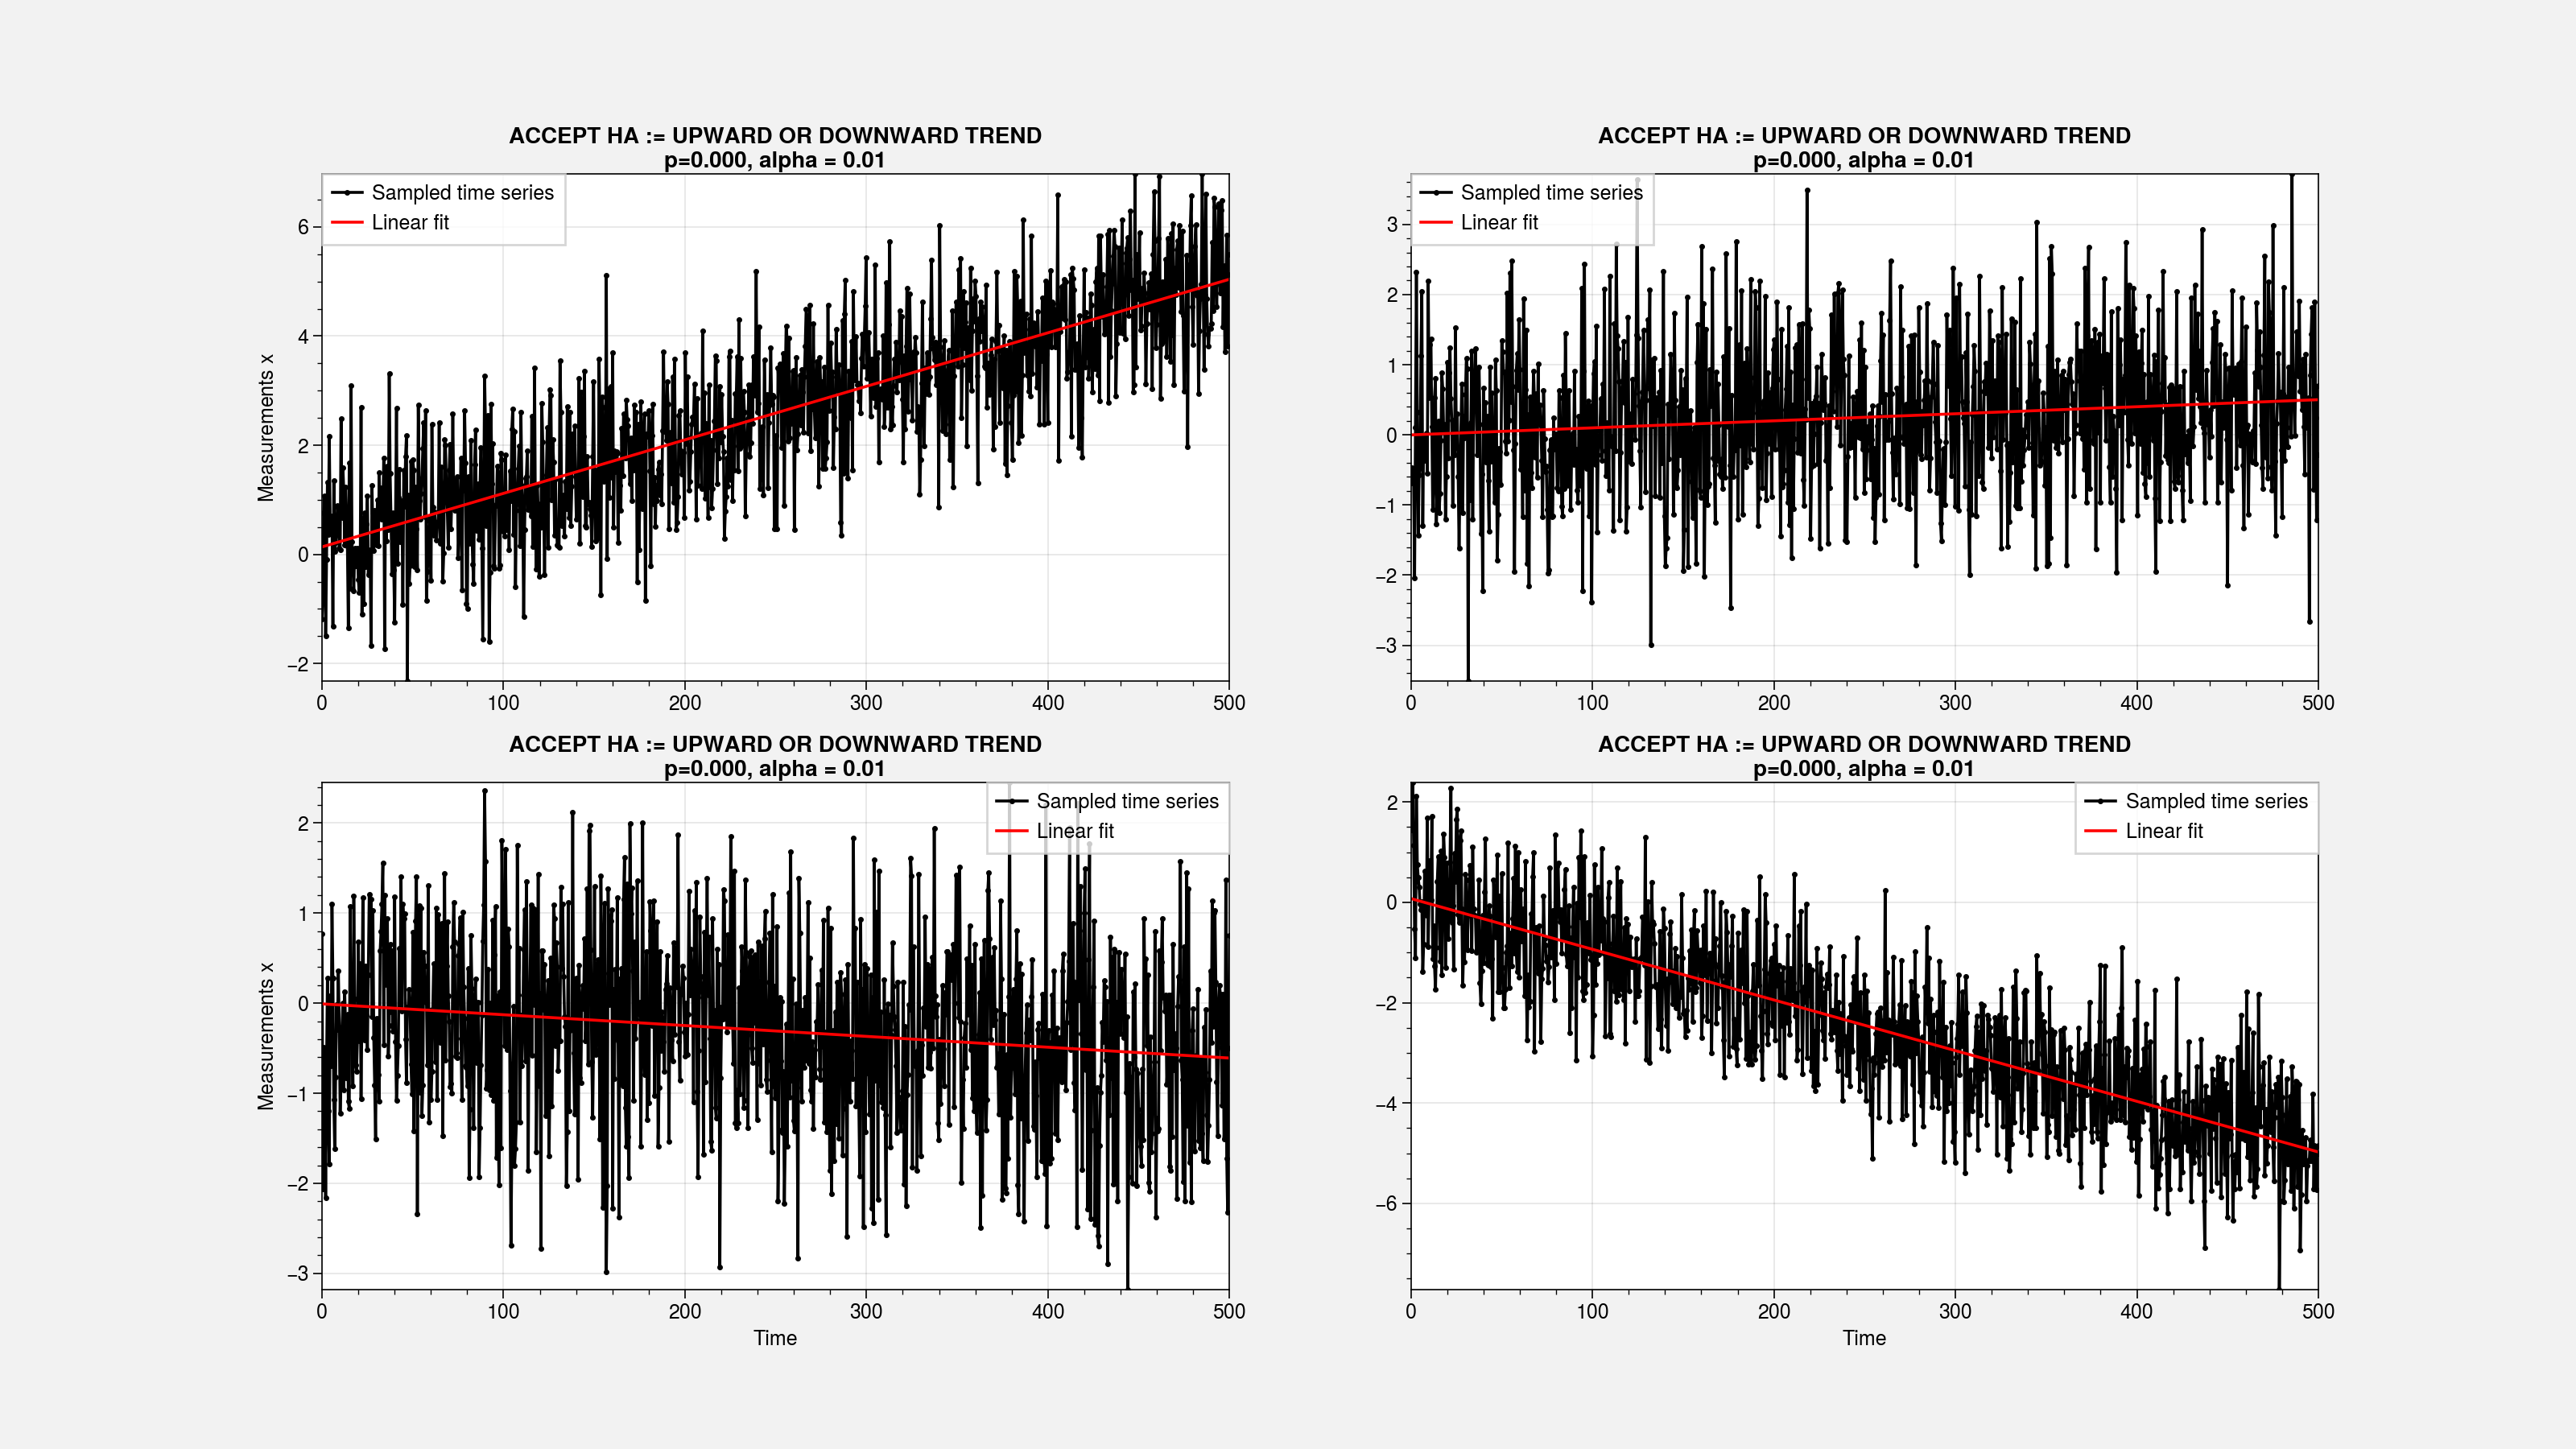

In [100]:
import matplotlib.pyplot as pl
def show_examples():
    """
    Returns the MK test results for artificial data.
    """
    # create artificial time series with trend
    n = 1000
    C = [0.01, 0.001, -0.001, -0.01]
    e = 1.00
    t = np.linspace(0., 500, n)

    # set up figure
    fig, axes = pl.subplots(nrows=2, ncols=2, figsize=[16.00, 9.00])

    # loop through various values of correlation
    ALPHA = 0.01
    for c, ax in zip(C, axes.flatten()):
        # estimate the measurements 'x'
        x = c * t +  e * np.random.randn(n)
        x = np.round(x, 2)

        # get the slope, intercept and pvalues from the mklt module
        MK, m, c, p = mkt.test(t, x, eps=1E-3, alpha=ALPHA, Ha="upordown")

        # plot results
        ax.plot(t, x, "k.-", label="Sampled time series")
        ax.plot(t, m * t + c, "r-", label="Linear fit")
        ax.set_title(MK.upper() + "\np=%.3f, alpha = %.2f" % (p, ALPHA),
                     fontweight="bold", fontsize=10)

        # prettify
        if ax.is_last_row():
            ax.legend(loc="upper right")
            ax.set_xlabel("Time")
        if ax.is_first_col():
            ax.set_ylabel(r"Measurements $x$")
        if ax.is_first_row():
            ax.legend(loc="upper left")

    # save/show plot
    pl.show(fig)
    return None

show_examples()

In [8]:
# Import metadata for the stations
md = pd.read_csv("../data/CETRAD/CETRADMetadata.csv")  # Read in the each stations metadata
md.head()

,Station Name,Annual Mean Rainfall,Annual SD Rainfall,UTM_x,UTM_y,Note
0,ARCHERS POST,355.741667,154.381690,351624.283,70807.012,NaN
1,ARDENCAPLE FARM,636.740616,226.335232,306006.828,9696.368,NaN
2,CASTLE FOREST STN,2033.627234,555.552122,311885.880,-44864.115,NaN
3,CHOGORIA FOREST STN,2225.510714,609.475564,343375.885,-26140.191,NaN
4,CHUKA FOREST STN,1915.845556,453.113081,344923.385,-34827.829,NaN


In [9]:
md.describe()

,Annual Mean Rainfall,Annual SD Rainfall,UTM_x,UTM_y
count,80.000000,80.000000,73.000000,73.000000
mean,846.456388,266.458853,280887.682932,4756.057425
std,366.869672,112.407249,38238.917088,33358.966855
min,355.557143,133.459860,194353.309000,-76827.970000
25%,636.573837,202.299506,263186.069000,-18075.287000
50%,725.021815,234.455798,284539.729000,4286.224000
75%,931.166310,291.891554,306006.828000,23732.173000
max,2225.510714,627.262341,351624.283000,122312.890000


In [11]:
# Return min, max, med:
md.sort_values(by='Annual Mean Rainfall')

# stations to use:
# L: OL JOGI FARM: 1967-1999, 32 years
# M: Kisima Farm
# H: TIMAU MARANIA: 1951-2015, # 64 years

,Station Name,Annual Mean Rainfall,Annual SD Rainfall,UTM_x,UTM_y,Note
39,MUKOGODO (NRM),355.557143,179.420270,284539.729,42749.591,NaN
0,ARCHERS POST,355.741667,154.381690,351624.283,70807.012,NaN
16,JUNCTION (EWASO NAROK),446.788571,192.403063,260384.335,56118.819,NaN
5,COLCHECCIO,450.030011,178.837883,255409.160,68804.307,NaN
6,DOL DOL DAO,518.613513,215.823611,295573.860,43649.450,NaN
...,...,...,...,...,...,...
32,MARIENE CRS,1717.150000,535.742714,349303.747,-934.868,NaN
13,IRANGI FOREST STN,1750.950000,554.512513,331263.832,-38102.665,NaN
4,CHUKA FOREST STN,1915.845556,453.113081,344923.385,-34827.829,NaN
2,CASTLE FOREST STN,2033.627234,555.552122,311885.880,-44864.115,NaN


### Step 2. Filter data

TODO: Put the three locations in a list and loop through the following procedure to determine r2, etc.

In [12]:
#station = 'ARDENCAPLE FARM' # 67 years of data
#station = 'JACOBSON FARM'
#station = 'EMBORI FARM'
station = 'OL JOGI FARM'
#station = 'TIMAU MARANIA'
columns = [station] + ['Year', 'Month', 'Datetime']
rainfall = df[columns]
rainfall.head()

,OL JOGI FARM,Year,Month,Datetime
Datetime,,,,
1934-01-01,NaN,1934,1,1934-01-01
1934-01-02,NaN,1934,1,1934-01-02
1934-01-03,NaN,1934,1,1934-01-03
1934-01-04,NaN,1934,1,1934-01-04
1934-01-05,NaN,1934,1,1934-01-05


Check out the data

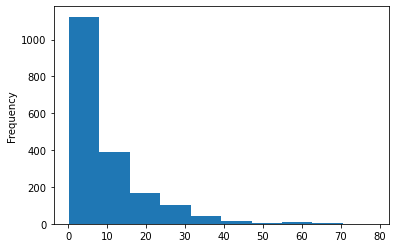

In [13]:
# Plot a histogram of rainfall values for days with rain.
daily_rainfall = rainfall.loc[rainfall[station] > 0][station]
daily_rainfall.plot.hist()

This looks okay, but we need to check and see how well the values in `daily_rainfall` fit our assumption of an exponential distribution.

### Step 3. Fit the distribution

To fit the distribution, we are going to use some more functions from `python`'s suite of numerical analysis. In this case we are going to use some functions from `scipy`. The [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html) module has a large suite of distribution functions pre-defined, which we can use to develop a fit for our data. Using any of these distributions for fitting our data is very easy. The distribution we are most interested in is the exponential distribution, which is called `expon` in the `stats` module.

In [14]:
import scipy.stats as st

distribution = st.expon
data = daily_rainfall
params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

print(params)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

(0.2, 9.355624327233585)


### Step 4. Calculate fitted PDF and error with fit in distribution

To test the fit of our distribution, we can compare the empirical histogram to that predicted by our model. To do this, we first use our `data` to generate the empirical histogram. In this exampkle, we break the data into `30` bins, and we generate a histrogram of `density` rather than counts. This allows for an easier comparison between our empirical data and the fitted probability distribution function. Here are the steps:

1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
2. Shift the `x` bin locations generated from the histogram to the center of bins.
3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according to:

$$ SS_{error} = \sum_{i=1}^{n} \left(y_i - f(x_i)\right)^2 $$
$$ SS_{yy} = \sum_{i=1}^{n} \left(y_i - \bar{y}\right)^2 $$

5. Calculate the $r^2$ of the fit, according to

$$ r^2 = 1- \frac{SS_{error}}{SS_{yy}} $$ 

 

In [15]:
# Step 1. Generate a density histogram of the data 
y, x = np.histogram(data, bins=30, density=True)

# Step 2. Shift the x bin locations to the center of bins.
x = (x + np.roll(x, -1))[:-1] / 2.0

# Step 3. Calculate the values of pdx(x) for all x.
pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

# Step 4. Determine the residual and total sum of the squares.
ss_error = np.sum(np.power(y - pdf, 2.0))
ss_yy = np.sum(np.power(y - y.mean(), 2.0))

r_2 = 1 - ( ss_error / ss_yy )
print(r_2)

0.978217870115316


This is an extremely good fit, so we can be confident that our assumption about an exponential distribution of rainfall is reasonable.

## Determining monthly values of  $\lambda_r$ 

We need to determine the probability of rainfall for each month by dividing the number of rainy days per month by the total number of observations in each month. For now, we assume stationarity in the monthly values, which means that we are assuming that the values of $\lambda_r$ in each month are the same through out the entire record (i.e. Jan 1938 has the same properties as Jan 2008). 

<div class="alert alert-info">💡 Test stationarity assumption </div>



As a first step, let's get all the `rain_days` and all of the `observation_days` from the data on `OL JOGI FARM`. We will use method chaining to run a **groupby()** as we go.

In [16]:
# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall[station] > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall[station] >= 0]

rain_days.head()

,OL JOGI FARM,Year,Month,Datetime
Datetime,,,,
1967-03-01,3.8,1967,3,1967-03-01
1967-03-02,50.7,1967,3,1967-03-02
1967-03-03,7.6,1967,3,1967-03-03
1967-03-21,1.0,1967,3,1967-03-21
1967-03-30,34.7,1967,3,1967-03-30


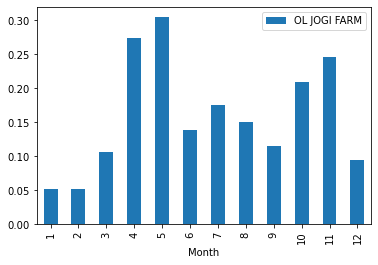

In [17]:
lambda_by_month = (
    rain_days.groupby('Month')[station].count() /
    all_days.groupby('Month')[station].count()
    )
pd.DataFrame(lambda_by_month).plot.bar()

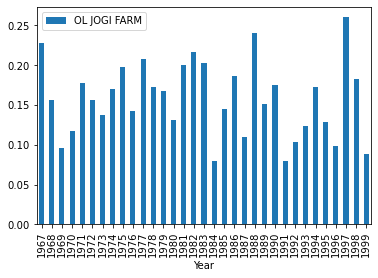

In [18]:
lambda_by_year = (
    rain_days.groupby('Year')[station].count() /
    all_days.groupby('Year')[station].count()
    )
pd.DataFrame(lambda_by_year).plot.bar()

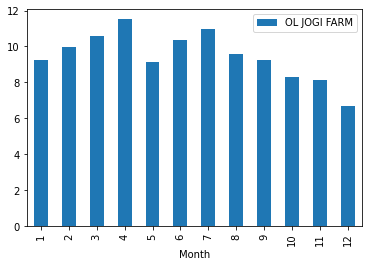

In [19]:
alpha_by_month = rain_days.groupby('Month')[station].mean()
pd.DataFrame(alpha_by_month).plot.bar()

In [20]:
climate = pd.DataFrame(alpha_by_month)
climate = climate.rename(columns={'OL JOGI FARM': 'alpha_by_month'})
climate['lambda_by_month'] = lambda_by_month
climate['days'] = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
climate['monthly_rainfall'] = climate['lambda_by_month'] * climate['alpha_by_month'] * climate['days']


climate_parameters = {
     'alpha_r': climate['alpha_by_month'].to_list(),
    'lambda_r': climate['lambda_by_month'].to_list(),
    'doy_start': 1,
    't_sim': 180,
    'ET_max': 6.5 
}

#dir(climate['alpha_by_month'])


climate = Climate(climate_parameters)

climate.rainfall.sum()

ValueError: lambda_r values and alpha_r values must be same length

## Simulating annual rainfall

To simulate annual rainfall, we are going to specify daily values of $\lambda_r$ using the monthly values we just calculated. The use of a variable $\lambda$ value in a poisson process creates what is known as an "inhomogenous poisson process" (or, alternatively, "nonhomogeneous"... unfortunately, there isn't much homogeneity in what we call it!). These types of processes allow the properties of the process to change in space and time. Our implementation - using monthly values - is a little clunky, and we'd prefer to have the $\lambda$ values change more smoothly throughout the year. However, we probably don't have sufficient data to allow for this, even if we could accomodate the more complicated coding it would require. 

In order to generate our nonhomogenous process we will first generate a daily array of month numbers for the year `2018`. This is really easy in python using `datetime` + `timedelta` (which we need to import).

```python
    import datetime
    from datetime import timedelta
    datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
    month_value = np.array([datetime.month for datetime in datetimes])
```

In [21]:
from datetime import timedelta, datetime
datetimes = np.arange(datetime(2018,1,1), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
month_value_by_day = np.array([datetime.month for datetime in datetimes])

## ToDo #1
## turn this into dekad_value_by_day

Month
1     0.051808
2     0.051502
3     0.105572
4     0.272917
5     0.304435
6     0.138542
7     0.174395
8     0.150202
9     0.114583
10    0.209157
11    0.246237
12    0.093652
Name: OL JOGI FARM, dtype: float64


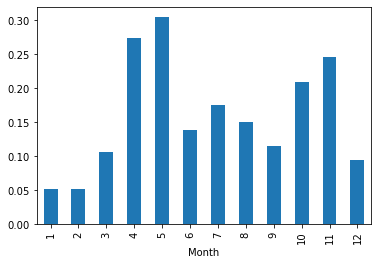

In [22]:
print(lambda_by_month)

## To-Do #1
## turn this into lambda_by_dekad

## To-Do #2
## turn this into plot, and plot for each station 
lambda_by_month.plot(kind='bar')

In [23]:
print(month_value_by_day)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11

`numpy` makes it really easy to map the values in one array onto the values of another.

```python
    lambda_values = [lambda_by_month[i] for i in month_value_by_day]
```

In [24]:
lambda_values = np.array([lambda_by_month[i] for i in month_value_by_day])

With daily values of $\lambda_r$, we only need to follow the same cookbook we used to make the seasonal data:

```python
    alpha = scale  # Let's use the value we estimated from our exponential fit.
    simulated_rainfall_values = np.random.exponential(
        scale=alpha, size=len(lambda_values)) # Use the len() function instead of a constant.
```

    

In [25]:
alpha = scale

simulated_rainy_days = (np.random.uniform(low=0, high=1, size=len(lambda_values)) <= lambda_values).astype(int)
simulated_rainfall_values = np.random.exponential(scale=alpha, size=len(lambda_values))

simulated_rainfall = simulated_rainy_days * simulated_rainfall_values

## Plotting our simulated data

We can easily plot our rainfall data using the `datetimes` object we already created as the basis of our x-axis.

<BarContainer object of 364 artists>

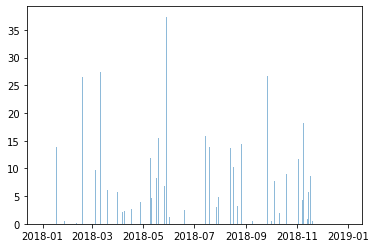

In [26]:
fig, ax = plt.subplots()

ax.bar(datetimes, simulated_rainfall, align='center', alpha=0.5)

<div class="alert alert-success">✏️ <strong>DIY Coding</strong>: Play around with our simulation. Here are a couple of ideas:</div>

1. Run 100 simulations of rainfall with our model for `JACOBSON FARM`. Compare the distribution of annual rainfall to the empirical distribution of annual rainfall.

2. Run the model for the same number of years that are in the `JACOBSON FARM` record and compare the mean and standard deviations of annual rainfall between the simulation and the empirical data. How well do they match?

2. Using the same simulations as in `2`, compare the mean and standard deviations of monthly rainfall between the simulation and the empirical data.

3. We've made $\lambda_r$ change every month, but we've used a constant $\alpha$ value. Determine if the assumption of a constant $\alpha$ is reasonable.

4. Determine the model parameters for a different station, preferably one with much lower or higher rainfall. How do the values of $\alpha$ and $\lambda_r$ change between stations?

5. Earlier I touched on the idea of non-stationarity in which the values of $\lambda_r$ and/or $\alpha$ may be changing over time. If you're up for it, see if you can come up with a way to investigate if our assumption of stationarity is valid.


In [99]:
# Not necessary


## 2. Simulate rainfall totals

Using a $\lambda_r$ value of <code>0.40</code>, and assuming that the length of a growing season, $T_{seas}$, is 100 days, simulate a season of rainfall "events", where the value of a day is <code>1</code> if rainfall occurs, and <code>0</code> if not.

In [2]:
T_seas = 100 # Days in each season
N_seas = 100 # Number of seasons to simulate
alpha = 11
s_mat = np.random.uniform(low=0, high=1, size=[N_seas, T_seas])
amounts = np.random.exponential(scale=alpha, size=[N_seas, T_seas])

lam = 0.4 # Lambda value
rain_days = np.array(s_mat <= lam).astype(int)
rain = rain_days * amounts
rain.sum(axis=1).std()/rain.sum(axis=1).mean() # Analytical equation for this!

0.20865081911871655